# Исследования массштабируемости Pregel+

### Описание вычислительной машины

- Процессор: AMD Ryzen 7 5800H (8 ядер, 16 потоков)

- L1-кэш: 64 KB (на ядро)
- L2-кэш: 512 KB (на ядро)
- L3-кэш: 16 MB (общий)

- RAM: 32 GB

- Операционная система: Ubuntu 24.04.2


Используемое ПО:

- GCC 11.4.0

- openjdk 8

- hadoop 2.6.1

- MPICH 3.1

### Описание эксперемента

**Цель:** Исследовать масштабируемость Pregel+ — как изменяется время выполнения и эффективность при увеличении числа процессов — на разных графах из датасета.


**Ход эксперимента:**
- Для каждого выбранного графа из датасета запускаем Pregel+ с использованием mpirun на 1, 2, 4, 8 и 16 процессах.
- Измеряем время выполнения, фиксируем результаты.
- Строим графики для каждого графа:
    - Зависимость времени выполнения от числа процессов
    - Зависимость ускорения и эффективности от числа процессов
- Сравниваем результаты и делаем выводы о масштабируемости Pregel+.

<!-- **Гипотезы:**
- Среднее время работы алгоритма Борувки на GraphBLAS будет меньше, чем на Pregel+, для данного набора графов
- Pregel+ будет существенную часть времени тратить на передачу сообщений в ходе работы -->

## Импорты

In [ ]:
%pip install lxml
%pip install requests
%pip install gdown
%pip install numpy
%pip install matplotlib
%pip install scipy
%pip install pandas

import os
import numpy as np
import tarfile
import subprocess
import shutil
import gzip
import requests
import time
import matplotlib.pyplot as plt

from scipy import stats
from collections import defaultdict
from lxml import etree
from collections import defaultdict

In [2]:
experiment_abs_path = os.path.abspath(".")
environment_abs_path = os.path.abspath("environment")
pregel_abs_path = os.path.abspath("pregel_mst")
data_abs_path = os.path.abspath("data")

## Графы

In [ ]:
os.chdir(data_abs_path)

!gdown 1jF_mofBBRULZh4rzKqZhhBRVuc2Pd8II
with tarfile.open("map_graphs.tar.gz", "r:gz") as tar:
    tar.extractall()

os.chdir(experiment_abs_path)

## Pregel+

#### Подготовка окружения

In [ ]:
me = subprocess.check_output("whoami", shell=True, text=True).strip()

password = ""

hdfs_path = "/app/hdfsEXP"

In [ ]:
command = f"echo {password} | sudo -S apt install openssh-server -y"
subprocess.run(command, shell=True, check=True)

command = f"echo {password} | sudo -S apt install ssh-askpass -y"
subprocess.run(command, shell=True, check=True)

command = f"echo {password} | sudo -S apt install mpich -y"
subprocess.run(command, shell=True, check=True)

command = f"echo {password} | sudo -S apt install g++ -y"
subprocess.run(command, shell=True, check=True)

SSH Конфигурация

И Hadoop, и MPI требуют беспарольного SSH-подключения. Если у вас SSH уже настроен, можно пропустить этот шаг.

In [ ]:
""" !ssh-keygen -R localhost
!ssh-keygen -t rsa -P '' -f ~/.ssh/id_rsa
!cat ~/.ssh/id_rsa.pub >> ~/.ssh/authorized_keys
!chmod 0600 ~/.ssh/authorized_keys """

In [ ]:
os.chdir(environment_abs_path)

# hadoop
!wget https://archive.apache.org/dist/hadoop/common/hadoop-2.6.1/hadoop-2.6.1.tar.gz
with tarfile.open("hadoop-2.6.1.tar.gz", "r:gz") as tar:
    tar.extractall()

# openjdk
!wget https://github.com/adoptium/temurin8-binaries/releases/download/jdk8u392-b08/OpenJDK8U-jdk_x64_linux_hotspot_8u392b08.tar.gz
with tarfile.open("OpenJDK8U-jdk_x64_linux_hotspot_8u392b08.tar.gz", "r:gz") as tar:
    tar.extractall()

In [9]:
hadoop_abs_path = environment_abs_path + "/hadoop-2.6.1"

In [ ]:
command1 = f"echo {password} | sudo -S chown {me}:sudo ./hadoop-2.6.1"
subprocess.run(command1, shell=True, check=True)

Обновим переменные окружения и сконфигурируем Hadoop

In [11]:
jav_home = os.path.abspath("jdk8u392-b08")
hadoo_home = os.path.abspath("hadoop-2.6.1")

with open("./.bashrc", "r") as file:
    content = file.read()

content = content.replace("jav_home", jav_home)
content = content.replace("hadoo_home", hadoo_home)

with open("./.bashrc", "w") as file:
    file.write(content)

In [ ]:
subprocess.run(["bash", "-c", "source ./.bashrc && env"], check=True)

In [ ]:
cmd = f"echo {password} | sudo -S mkdir -p {hdfs_path}"

try:
    subprocess.run(cmd, shell=True, check=True)
    print("Directory created successfully")
except subprocess.CalledProcessError as e:
    print(f"Error creating directory: {e}")

command1 = f"echo {password} | sudo -S chown {me}:sudo {hdfs_path}"
subprocess.run(command1, shell=True, check=True)

command2 = f"echo {password} | sudo -S chmod 755 {hdfs_path}"
subprocess.run(command2, shell=True, check=True)

In [39]:
subprocess.run(
    [
        "cp",
        "hadoop-2.6.1/etc/hadoop/mapred-site.xml.template",
        "hadoop-2.6.1/etc/hadoop/mapred-site.xml",
    ],
    check=True,
)

CompletedProcess(args=['cp', 'hadoop-2.6.1/etc/hadoop/mapred-site.xml.template', 'hadoop-2.6.1/etc/hadoop/mapred-site.xml'], returncode=0)

In [ ]:
def update_hadoop_configs():
    configs = {
        "hadoop-2.6.1/etc/hadoop/core-site.xml": [
            {"name": "hadoop.tmp.dir", "value": hdfs_path},
            {"name": "fs.default.name", "value": "hdfs://localhost:9000"},
        ],
        "hadoop-2.6.1/etc/hadoop/mapred-site.xml": [
            {"name": "mapred.job.tracker", "value": "hdfs://localhost:9001"}
        ],
        "hadoop-2.6.1/etc/hadoop/hdfs-site.xml": [
            {"name": "dfs.replication", "value": "3"}
        ],
    }

    parser = etree.XMLParser(remove_blank_text=True)

    for file_path, properties in configs.items():
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        shutil.copy2(file_path, f"{file_path}.bak")

        try:
            tree = etree.parse(file_path, parser)
            root = tree.getroot()

            config = root.find("configuration")
            if config is None:
                config = etree.SubElement(root, "configuration")

            for prop in config.findall("property"):
                config.remove(prop)

            for prop in properties:
                new_prop = etree.SubElement(config, "property")
                new_prop.text = "\n    "

                name = etree.SubElement(new_prop, "name")
                name.text = prop["name"]
                name.tail = "\n    "

                value = etree.SubElement(new_prop, "value")
                value.text = prop["value"]
                value.tail = "\n"

                new_prop.tail = "\n\n"

            if len(config) > 0:
                config[-1].tail = "\n"

            with open(file_path, "wb") as f:
                f.write(b"<?xml version='1.0' encoding='UTF-8'?>\n")
                f.write(
                    b'<?xml-stylesheet type="text/xsl" href="configuration.xsl"?>\n'
                )

                for comment in root.xpath("//comment()"):
                    f.write(etree.tostring(comment, encoding="UTF-8") + b"\n")

                f.write(
                    b"<!-- Put site-specific property overrides in this file. -->\n"
                )
                f.write(etree.tostring(config, encoding="UTF-8", pretty_print=True))

            print(f"Successfully updated {file_path}")

        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            shutil.copy2(f"{file_path}.bak", file_path)


update_hadoop_configs()

In [ ]:
hadoop_dir = "hadoop-2.6.1"
target_dir = os.path.join(hadoop_dir, "etc", "hadoop")
file_path = os.path.join(target_dir, "masters")

os.makedirs(target_dir, exist_ok=True)

with open(file_path, "w") as file:
    file.write("localhost")

print(f"File '{file_path}' created successfully with content 'localhost'")

In [42]:
java_home = os.path.abspath("jdk8u392-b08")

hadoop_dir = "hadoop-2.6.1"
env_file = os.path.join(hadoop_dir, "etc", "hadoop", "hadoop-env.sh")

with open(env_file, "r") as file:
    lines = file.readlines()

modified_lines = []
for line in lines:
    if line.strip().startswith("export JAVA_HOME=") and "${JAVA_HOME}" in line:
        line = f"export JAVA_HOME={java_home}\n"
    modified_lines.append(line)

with open(env_file, "w") as file:
    file.writelines(modified_lines)

In [ ]:
os.chdir(environment_abs_path)
subprocess.run(
    ["bash", "-c", "hadoop-2.6.1/bin/hadoop namenode -format"],
    input="Y\n",
    text=True,
    check=True,
)

Запустим Hadoop

In [ ]:
subprocess.run(["bash", "-c", "hadoop-2.6.1/sbin/start-dfs.sh"], check=True)

In [ ]:
os.chdir(pregel_abs_path)

subprocess.run("make", shell=True, check=True)

## Замеры

In [ ]:
os.chdir(environment_abs_path)
os.mkdir("pregel_results")

Основные функции, запускающие алгоритм, считающие время работы и итоговый вес полученного дерева

In [ ]:
def run_experiment_pregel_helper(
    algorithm,
    time_file,
    prefix,
    np_list,
):
    with open(time_file, "w") as f:
        f.write("")

    binary = {
        "mst": "run",
        "msbfs": "run_msbfs"
    }[algorithm]

    for np in np_list:
        for r in range(20):
            start_time = time.time()
            subprocess.run(
                ["bash", "-c", "hadoop-2.6.1/bin/hadoop fs -rm -r /toyOutput"],
                check=False
            )

            subprocess.run(
                ["mpirun", "-np", str(np), pregel_abs_path + f"/{binary}"],
                check=True
            )
            elapsed_time = time.time() - start_time

            output_file = f"{prefix}_output_{algorithm}_{np}.txt"

            subprocess.run(
                ["bash", "-c",
                f"../../hadoop-2.6.1/bin/hadoop fs -cat /toyOutput/* >> {output_file}"],
                check=True
            )

            with open(time_file, "a") as f:
                f.write(f"{np} {elapsed_time}\n")

            os.remove(output_file)


def run_pregel_experiment(
    algorithm,
    graph_file,
    graph_name,
    environment_abs_path,
    np_list=[4]
):
    os.chdir(environment_abs_path)

    try:
        subprocess.run(
            ["bash", "-c", "hadoop-2.6.1/bin/hadoop fs -rm -r /toyFolder"],
            check=True
        )
    except Exception:
        pass

    subprocess.run(
        ["bash", "-c",
         f"hadoop-2.6.1/bin/hadoop fs -put ../data/{graph_file} /toyFolder"],
        check=True
    )

    results_dir = f"pregel_results/{graph_name}_{algorithm}_results"
    os.makedirs(results_dir, exist_ok=True)
    os.chdir(results_dir)

    time_file = f"{graph_name}_time_{algorithm}.txt"


    run_experiment_pregel_helper(
        algorithm=algorithm,
        time_file=time_file,
        prefix=graph_name,
        np_list=np_list,
    )

    os.chdir(environment_abs_path)

    subprocess.run(
        ["bash", "-c", "hadoop-2.6.1/bin/hadoop fs -rm -r /toyFolder"],
        check=True
    )



# Эксперимент 1: Борувка на DIMACS 9th

## New York City (Вершин: 264,346; Ребер: 365,050)

In [ ]:
run_pregel_experiment(
    algorithm="mst",
    graph_file="Plus_USA-road-d.NY.gr",
    graph_name="NY",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
)

In [ ]:
os.chdir(environment_abs_path)
pregel_results_NY_abs_path = os.path.abspath("pregel_results/NY_results")

## San Francisco Bay Area (Вершин: 321,270; Ребер: 397,415)

In [ ]:
run_pregel_experiment(
    algorithm="mst",
    graph_file="Plus_USA-road-d.BAY.gr",
    graph_name="BAY",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
)

In [ ]:
os.chdir(environment_abs_path)
pregel_results_BAY_abs_path = os.path.abspath("pregel_results/BAY_results")

## Colorado (Вершин: 435,666; Ребер: 521,200)

In [ ]:
run_pregel_experiment(
    algorithm="mst",
    graph_file="Plus_USA-road-d.COL.gr",
    graph_name="COL",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
)

In [ ]:
os.chdir(environment_abs_path)
pregel_results_COL_abs_path = os.path.abspath("pregel_results/COL_results")

## Florida (Вершин: 1,070,376; Ребер: 1,343,951)

In [ ]:
run_pregel_experiment(
    algorithm="mst",
    graph_file="Plus_USA-road-d.FLA.gr",
    graph_name="FLA",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
)

In [ ]:
os.chdir(environment_abs_path)
pregel_results_FLA_abs_path = os.path.abspath("pregel_results/FLA_results")

## Northwest USA (Вершин: 1,207,945; Ребер: 1,410,387)

In [ ]:
run_pregel_experiment(
    algorithm="mst",
    graph_file="Plus_USA-road-d.NW.gr",
    graph_name="NW",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
)

In [ ]:
os.chdir(environment_abs_path)
pregel_results_NW_abs_path = os.path.abspath("pregel_results/NW_results")

## Northeast USA (Вершин: 1,524,453; Ребер: 1,934,010)

In [ ]:
run_pregel_experiment(
    algorithm="mst",
    graph_file="Plus_USA-road-d.NE.gr",
    graph_name="NE",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
)

In [ ]:
os.chdir(environment_abs_path)
pregel_results_NE_abs_path = os.path.abspath("pregel_results/NE_results")

## California and Nevada (Вершин: 1,890,815; Ребер: 2,315,222)

In [ ]:
run_pregel_experiment(
    algorithm="mst",
    graph_file="Plus_USA-road-d.CAL.gr",
    graph_name="CAL",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
)

In [ ]:
os.chdir(environment_abs_path)
pregel_results_CAL_abs_path = os.path.abspath("pregel_results/CAL_results")

## Great Lakes (Вершин: 2,758,119; Ребер: 3,397,404)

In [ ]:
run_pregel_experiment(
    algorithm="mst",
    graph_file="Plus_USA-road-d.LKS.gr",
    graph_name="LKS",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
)

In [ ]:
os.chdir(environment_abs_path)
pregel_results_LKS_abs_path = os.path.abspath("pregel_results/LKS_results")

# Эксперимент 2: MS-Parent BFS на SNAP

##  Twitch gamers network (Вершин: 168,114; Ребер: 6,797,557)

In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="TWITCH_GAMERS_pbfs.pp",
    graph_name="TWITCH_GAMERS",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
os.chdir(environment_abs_path)
pregel_results_TWITCH_GAMERS_abs_path = os.path.abspath(
    "pregel_results/TWITCH_GAMERS_msbfs_results"
)

## Gemsec Facebook dataset (Вершин: 134,833; Рёбер: 1,380,293)

In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="FB_GEMSEC_pbfs.pp",
    graph_name="FB_GEMSEC",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
os.chdir(environment_abs_path)
pregel_results_FB_GEMSEC_abs_path = os.path.abspath(
    "pregel_results/FB_GEMSEC_msbfs_results"
)

## Gemsec Deezer dataset (Вершин: 143,884; Рёбер: 846,915)

In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="DEEZER_pbfs.pp",
    graph_name="DEEZER",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
os.chdir(environment_abs_path)
pregel_results_DEEZER_abs_path = os.path.abspath(
    "pregel_results/DEEZER_msbfs_results"
)

## Twitch social networks (Вершин: 34,118; Рёбер: 429,113)


In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="TWITCH_SOC_pbfs.pp",
    graph_name="TWITCH_SOC",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
os.chdir(environment_abs_path)
pregel_results_TWITCH_SOC_abs_path = os.path.abspath(
    "pregel_results/TWITCH_SOC_msbfs_results"
)

## GitHub developer network (Вершин: 37,700; Рёбер: 289,003)

In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="GITHUB_pbfs.pp",
    graph_name="GITHUB",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
os.chdir(environment_abs_path)
pregel_results_GITHUB_abs_path = os.path.abspath(
    "pregel_results/GITHUB_msbfs_results"
)

## Facebook page-page network (Вершин: 22,470; Рёбер: 171,002)

In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="FB_PAGES_pbfs.pp",
    graph_name="FB_PAGES",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
os.chdir(environment_abs_path)
pregel_results_FB_PAGES_abs_path = os.path.abspath(
    "pregel_results/FB_PAGES_msbfs_results"
)

## Facebook social circles (Вершин: 4,039; Рёбер: 88,234)

In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="FB_CIRCLES_pbfs.pp",
    graph_name="FB_CIRCLES",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
os.chdir(environment_abs_path)
pregel_results_FB_CIRCLES_abs_path = os.path.abspath(
    "pregel_results/FB_CIRCLES_msbfs_results"
)

## Deezer Europe social network (Вершин: 28,281; Рёбер: 92,752)

In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="DEEZER_EU_pbfs.pp",
    graph_name="DEEZER_EU",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
os.chdir(environment_abs_path)
pregel_results_DEEZER_EU_abs_path = os.path.abspath(
    "pregel_results/DEEZER_EU_msbfs_results"
)

## LastFM Asia social network (Вершин: 7,624; Рёбер: 27,806)

In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="LASTFM_pbfs.pp",
    graph_name="LASTFM",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
os.chdir(environment_abs_path)
pregel_results_LASTFM_abs_path = os.path.abspath(
    "pregel_results/LASTFM_msbfs_results"
)

## Проверка результатов

In [3]:
os.chdir(environment_abs_path)
pregel_results_abs_path = os.path.abspath("pregel_results/")

In [4]:
PREFIXES_DIMACS = [
    "NY",
    "BAY",
    "COL",
    "FLA",
    "NW",
    "NE",
    "CAL",
    "LKS"
]

In [5]:
PREFIXES_SNAP = [
    "TWITCH_GAMERS",
    "FB_GEMSEC",
    "DEEZER",
    "TWITCH_SOC",
    "GITHUB",
    "FB_PAGES",
    "FB_CIRCLES",
    "DEEZER_EU",
    "LASTFM",
]

## Передача сообщений

Воспользуемся mpiP &ndash; профилировщиком для программ, которые используют MPI. Для чистоты эксперемента проделаем заново предыдущие запуски для Pregel+, но уже с профилировщиком.

Установим mpiP

In [ ]:
os.chdir(environment_abs_path)

clone_cmd = "git clone https://github.com/LLNL/mpiP.git"
subprocess.run(clone_cmd, shell=True, check=True)

os.chdir("mpiP")
subprocess.run("./configure", shell=True, check=True)
subprocess.run("make", shell=True, check=True)

os.chdir(environment_abs_path)

Пересоберем Pregel+ с профилировщиком

In [ ]:
os.chdir(pregel_abs_path)
subprocess.run("make clean", shell=True, check=True)
subprocess.run("make BUILD_TYPE=mpip", shell=True, check=True)

In [ ]:
def run_profiled_pregel(graph_file, graph_name, environment_abs_path, pregel_abs_path):
    os.chdir(environment_abs_path)

    try:
        subprocess.run(
            ["bash", "-c", "hadoop-2.6.1/bin/hadoop fs -rm -r /toyFolder"], check=True
        )
    except Exception as _:
        pass

    subprocess.run(
        [
            "bash",
            "-c",
            f"hadoop-2.6.1/bin/hadoop fs -put ../data/{graph_file} /toyFolder",
        ],
        check=True,
    )

    results_dir = f"pregel_results/{graph_name}_results"
    os.makedirs(results_dir, exist_ok=True)
    os.chdir(results_dir)

    for _ in range(1, 31):
        subprocess.run(["mpirun", "-np", "14", pregel_abs_path + "/run"])

    os.chdir(environment_abs_path)
    subprocess.run(
        ["bash", "-c", "hadoop-2.6.1/bin/hadoop fs -rm -r /toyFolder"], check=True
    )
    os.chdir(environment_abs_path)

Запустим заново Pregel+, но теперь после каждого запуска, mpip будет создавать файл-репорт о времени работы программы, и время, потраченное на работу с сообщениями 

In [ ]:
run_pregel_experiment(
    algorithm="mst",
    graph_file="Plus_USA-road-d.NY.gr",
    graph_name="NY",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
run_pregel_experiment(
    algorithm="mst",
    graph_file="Plus_USA-road-d.BAY.gr",
    graph_name="BAY",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
run_pregel_experiment(
    algorithm="mst",
    graph_file="Plus_USA-road-d.COL.gr",
    graph_name="COL",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
run_pregel_experiment(
    algorithm="mst",
    graph_file="Plus_USA-road-d.FLA.gr",
    graph_name="FLA",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
run_pregel_experiment(
    algorithm="mst",
    graph_file="Plus_USA-road-d.NW.gr",
    graph_name="NW",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
run_pregel_experiment(
    algorithm="mst",
    graph_file="Plus_USA-road-d.NE.gr",
    graph_name="NE",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
run_pregel_experiment(
    algorithm="mst",
    graph_file="Plus_USA-road-d.CAL.gr",
    graph_name="CAL",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
run_pregel_experiment(
    algorithm="mst",
    graph_file="Plus_USA-road-d.LKS.gr",
    graph_name="LKS",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="TWITCH_GAMERS_pbfs.pp",
    graph_name="TWITCH_GAMERS",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="FB_GEMSEC_pbfs.pp",
    graph_name="FB_GEMSEC",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="DEEZER_pbfs.pp",
    graph_name="DEEZER",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="TWITCH_SOC_pbfs.pp",
    graph_name="TWITCH_SOC",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="GITHUB_pbfs.pp",
    graph_name="GITHUB",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="FB_PAGES_pbfs.pp",
    graph_name="FB_PAGES",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="FB_CIRCLES_pbfs.pp",
    graph_name="FB_CIRCLES",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="DEEZER_EU_pbfs.pp",
    graph_name="DEEZER_EU",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

In [ ]:
run_pregel_experiment(
    algorithm="msbfs",
    graph_file="LASTFM_pbfs.pp",
    graph_name="LASTFM",
    environment_abs_path=environment_abs_path,
    np_list=[1, 2, 4, 8, 16]
)

## Результаты и графики

In [ ]:
def read_time_file(path):
    
    np_list = []
    times = []

    with open(path) as f:
        for line in f:
            if not line.strip():
                continue
            p, t = line.split()
            np_list.append(int(p))
            times.append(float(t))

    return np.array(np_list), np.array(times)


In [ ]:
def aggregate_by_np(np_vals, times):
    
    buckets = defaultdict(list)
    for p, t in zip(np_vals, times):
        buckets[p].append(t)

    ps = sorted(buckets.keys())
    means = np.array([np.mean(buckets[p]) for p in ps])
    stds = np.array([np.std(buckets[p], ddof=1) for p in ps])

    return np.array(ps), means, stds


In [ ]:
def plot_scalability_row(ps, means, stds, graph, time_unit="s"):

    if time_unit == "us":
        scale = 1e6
        ylabel = "Time (μs)"
    else:
        scale = 1.0
        ylabel = "Time (s)"

    means_scaled = means * scale
    stds_scaled = stds * scale

    T1 = means[ps == 1][0]
    speedup = T1 / means
    efficiency = speedup / ps

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    fig.suptitle(f"Pregel+ scalability — {graph}", fontsize=14)

    # --- Time ---
    axes[0].errorbar(
        ps, means_scaled, yerr=stds_scaled,
        marker="o", capsize=5
    )
    axes[0].set_xlabel("Processes")
    axes[0].set_ylabel(ylabel)
    axes[0].set_title("Execution time")
    axes[0].grid(True)

    # --- Speedup ---
    axes[1].plot(ps, speedup, marker="o", color="tab:green", label="Measured")
    axes[1].set_xlabel("Processes")
    axes[1].set_ylabel("Speedup")
    axes[1].set_title("Speedup")
    axes[1].legend()
    axes[1].grid(True)

    # --- Efficiency ---
    axes[2].plot(ps, efficiency, marker="o", color="tab:red", label="Measured")
    axes[2].axhline(0.5, color='green', linestyle='--', label="Efficiency = 0.5")
    axes[2].axhline(0.3, color='gray', linestyle='--', label="Efficiency = 0.3")
    axes[2].set_xlabel("Processes")
    axes[2].set_ylabel("Efficiency")
    axes[2].set_title("Efficiency")
    axes[2].legend()
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


## Борувка

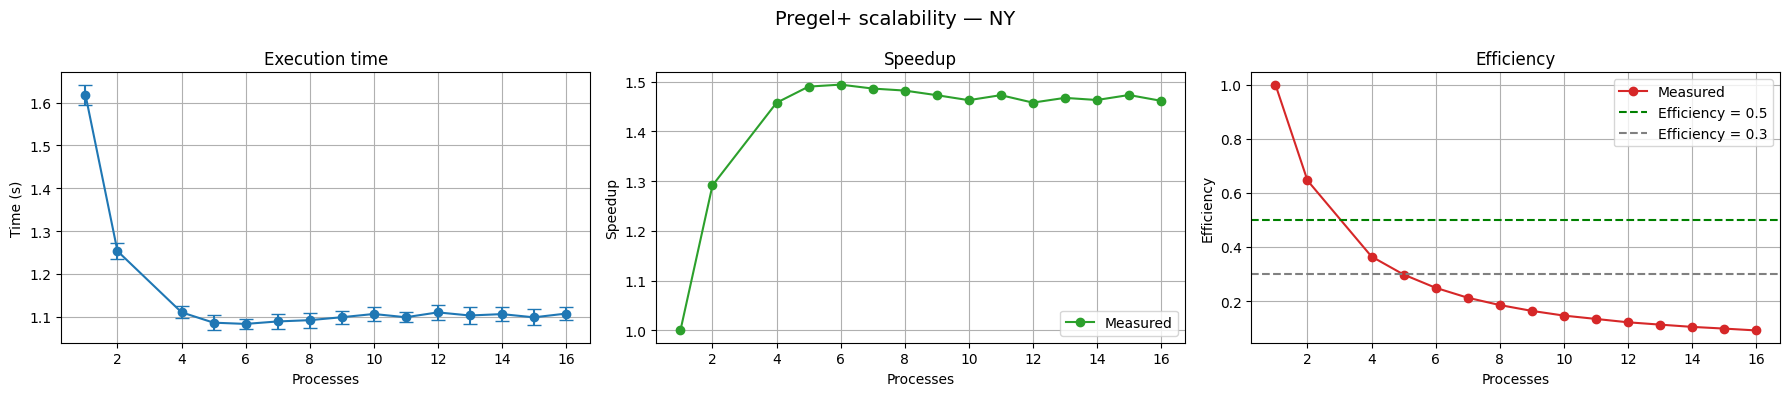

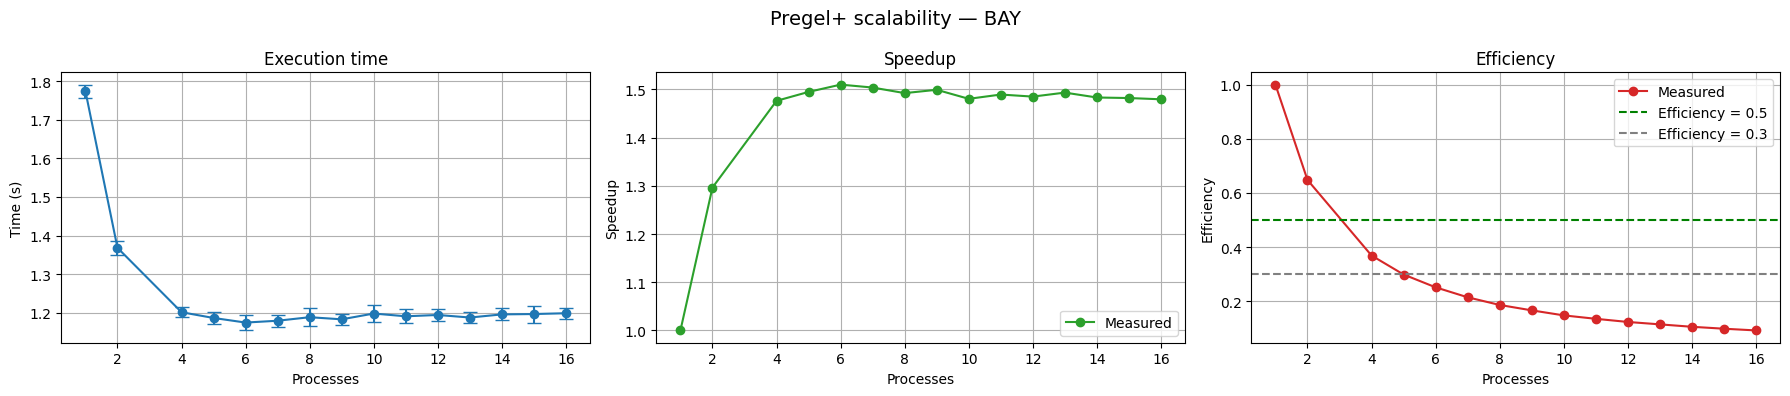

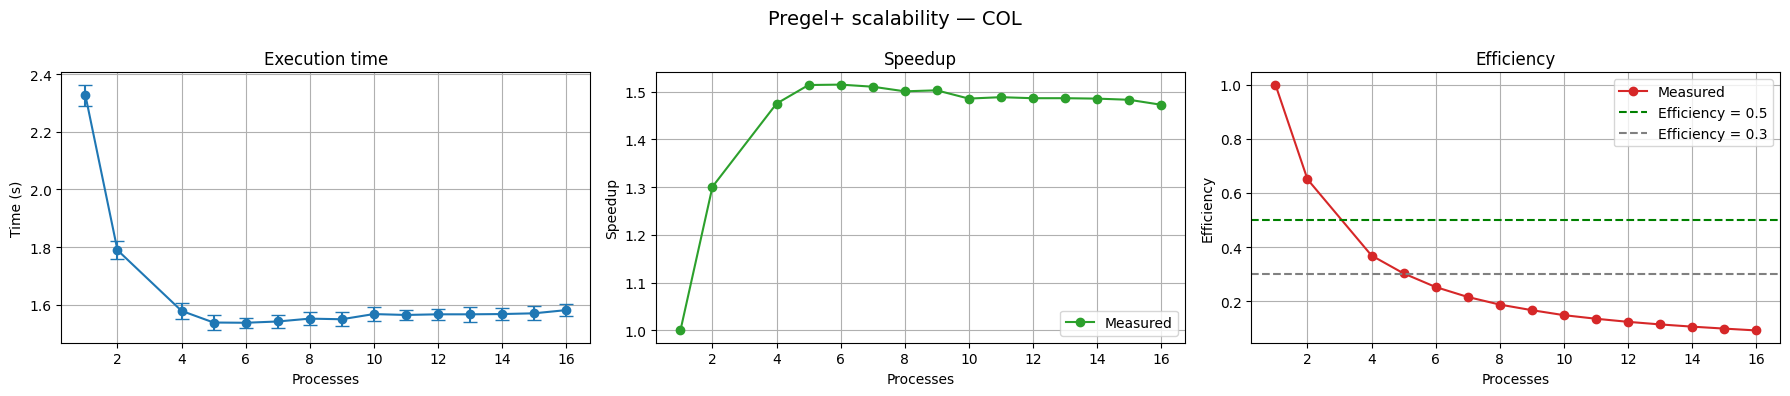

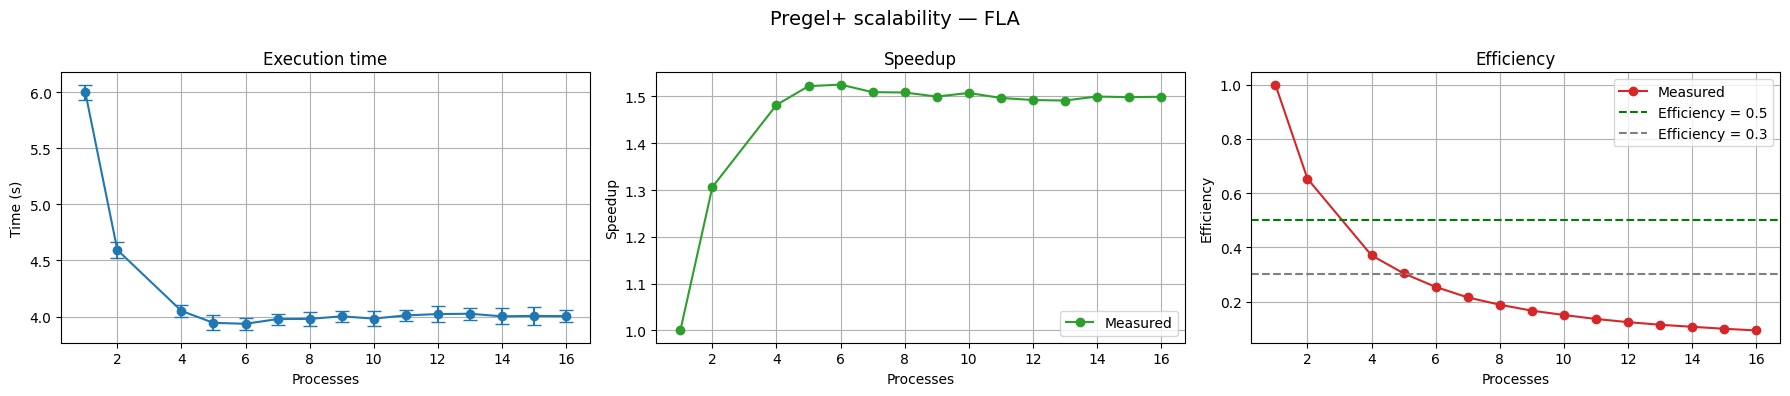

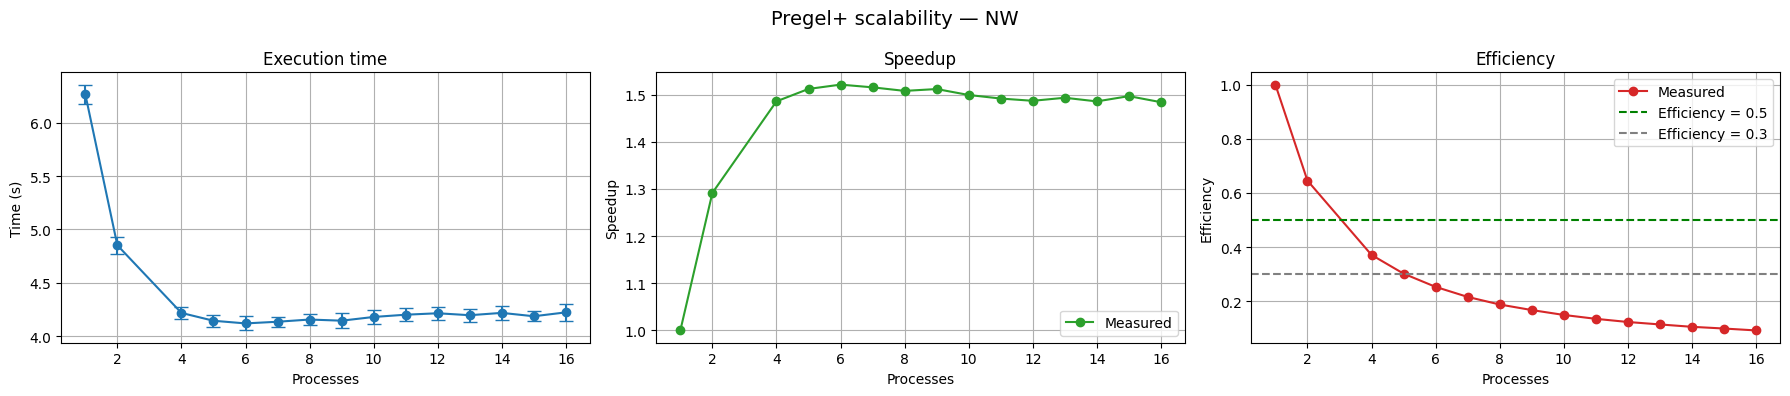

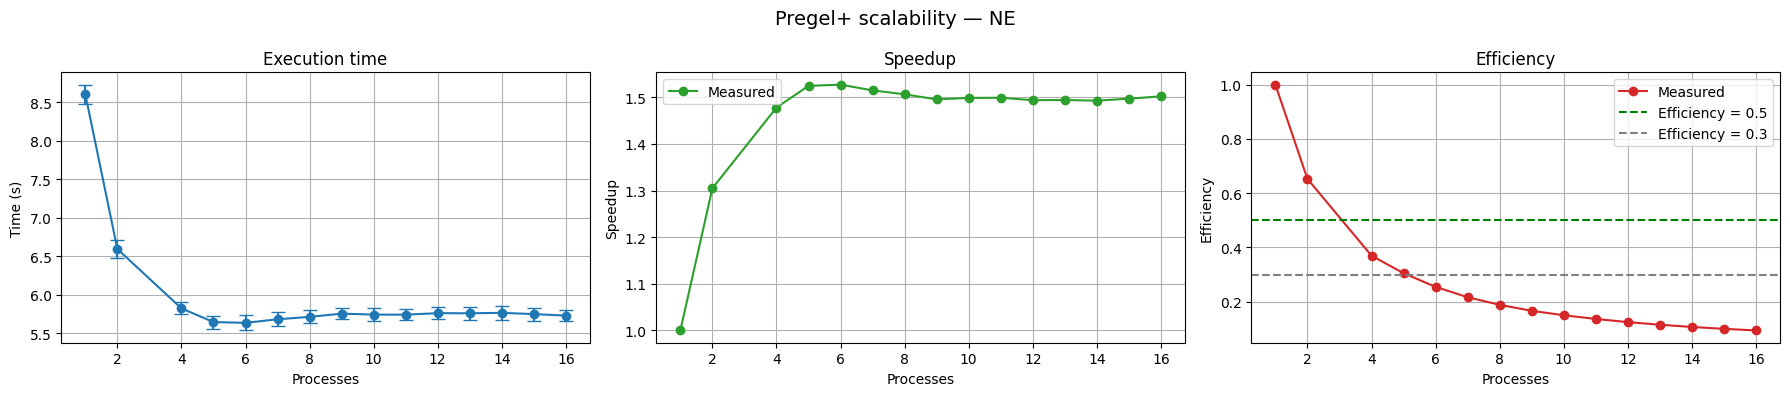

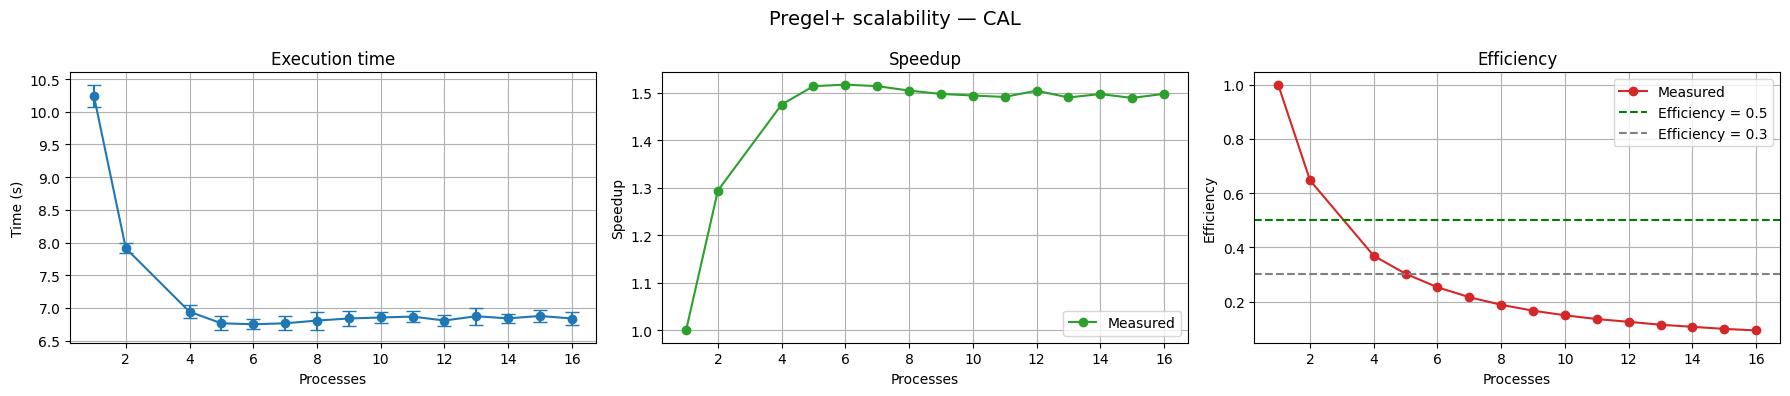

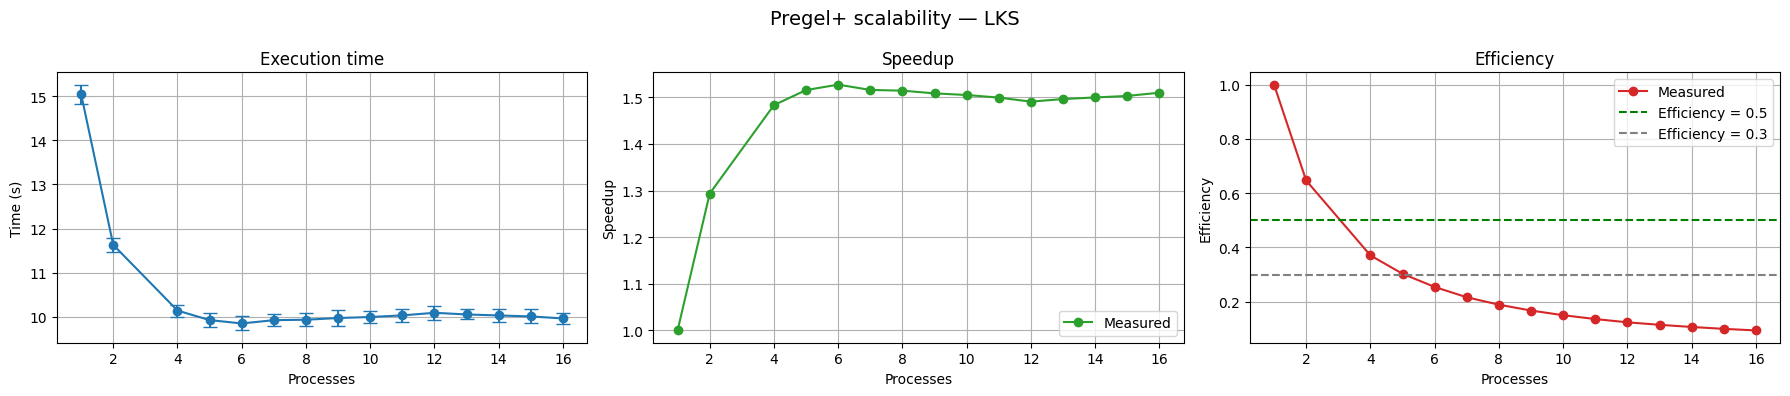

In [10]:
for graph in PREFIXES_DIMACS:
    path = os.path.join(
        pregel_results_abs_path,
        f"{graph}_mst_results",
        f"{graph}_time_mst.txt"
    )

    ps_raw, times_raw = read_time_file(path)
    ps, means, stds = aggregate_by_np(ps_raw, times_raw)

    plot_scalability_row(ps, means, stds, graph, time_unit="s")


## MS-Parent BFS

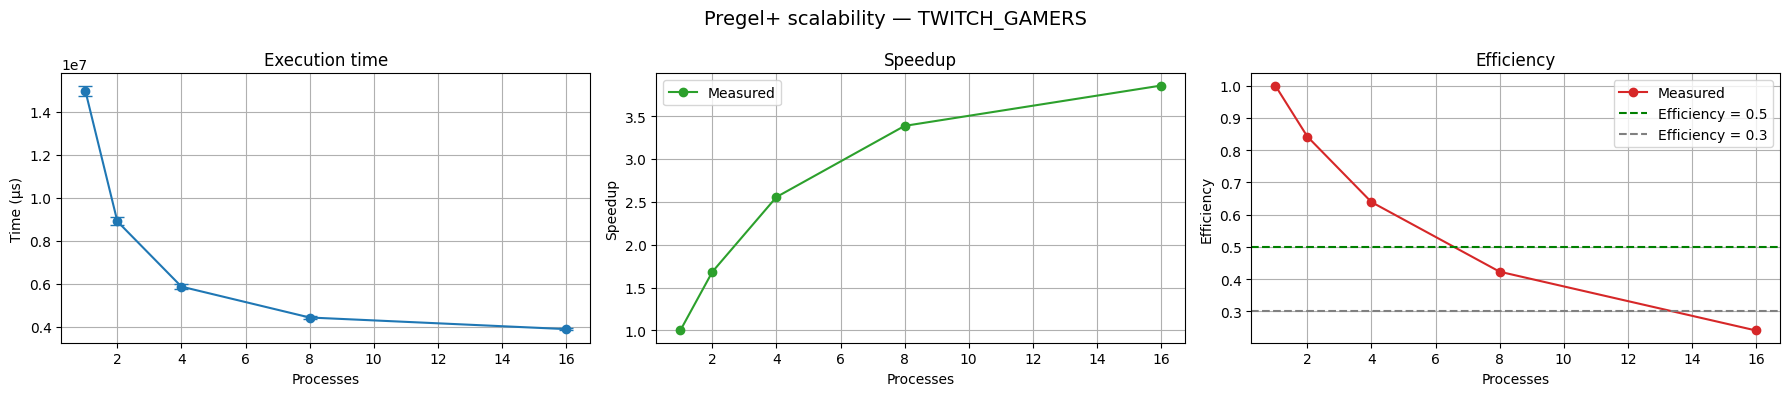

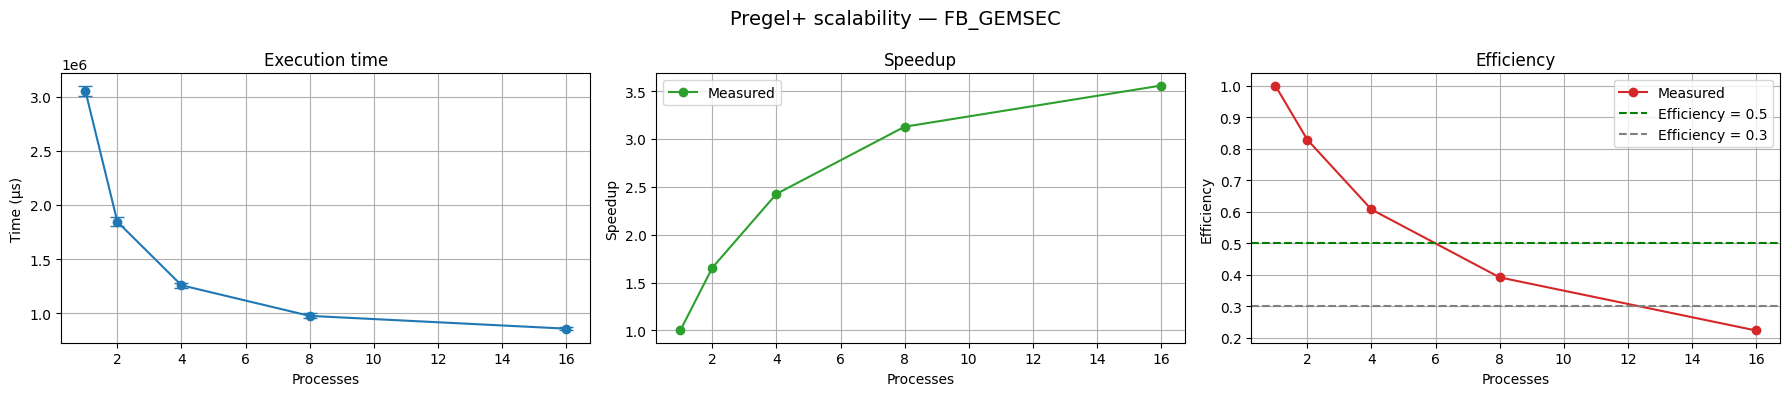

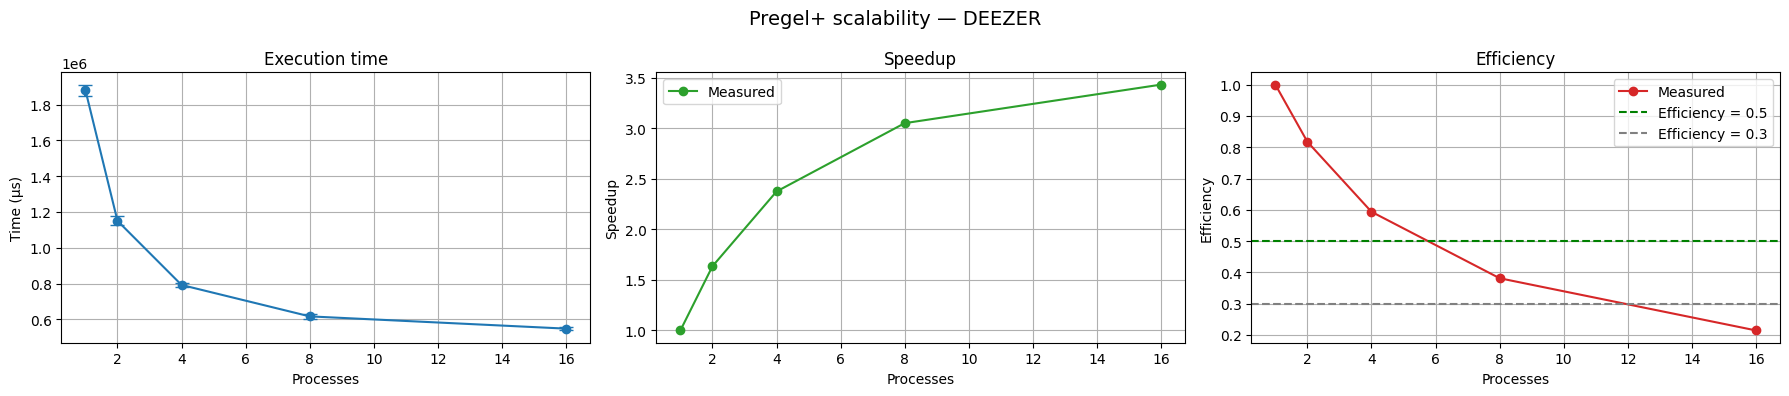

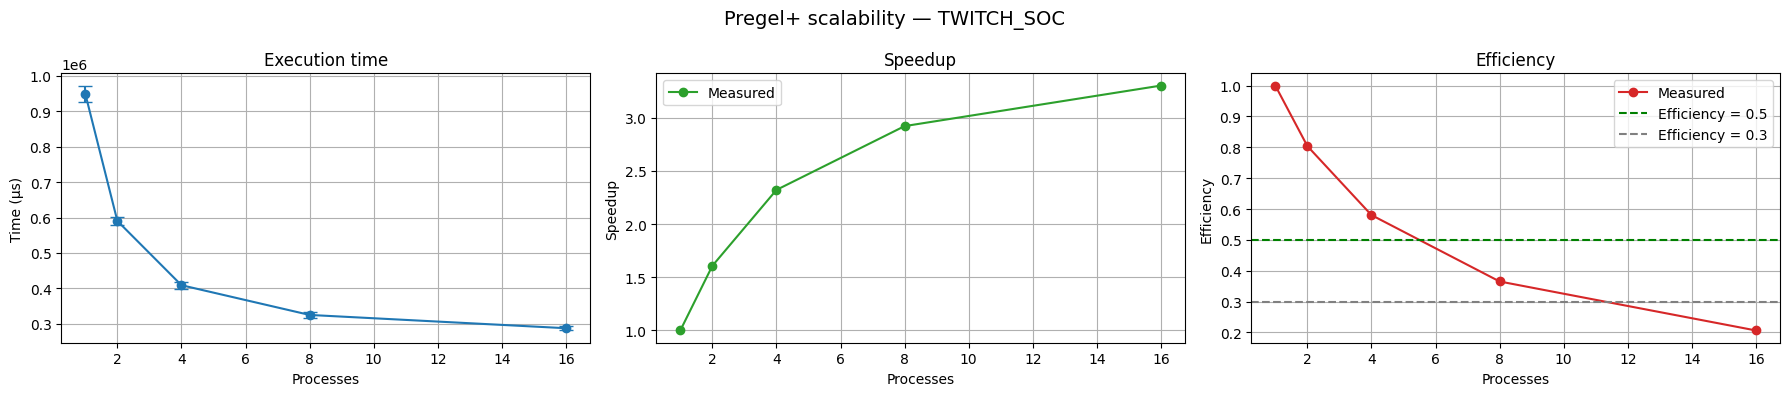

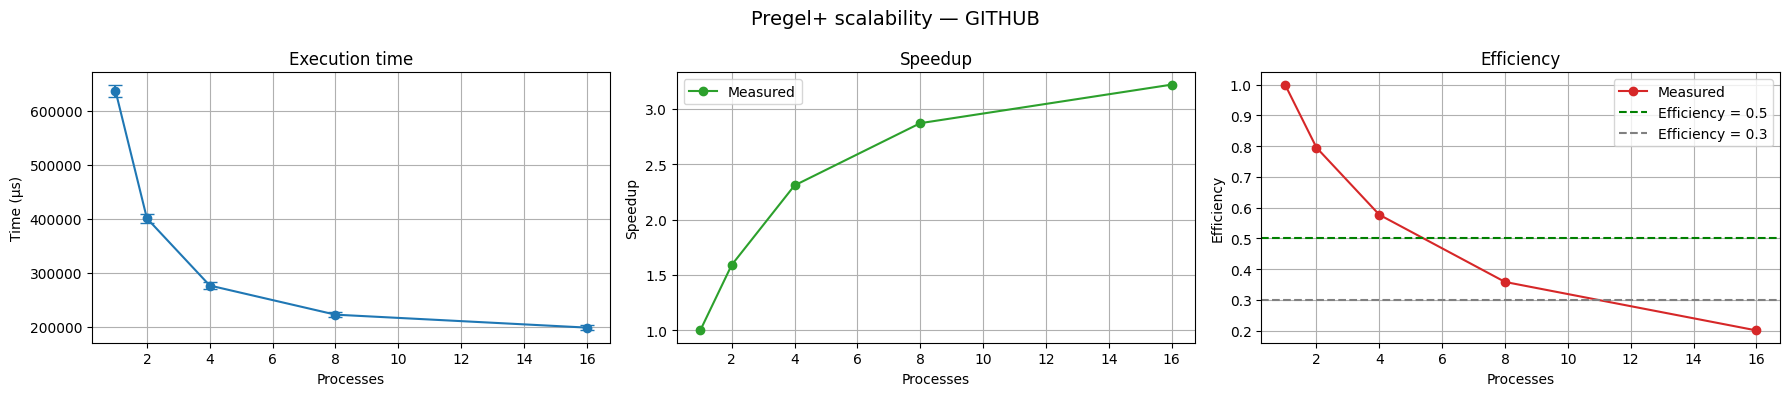

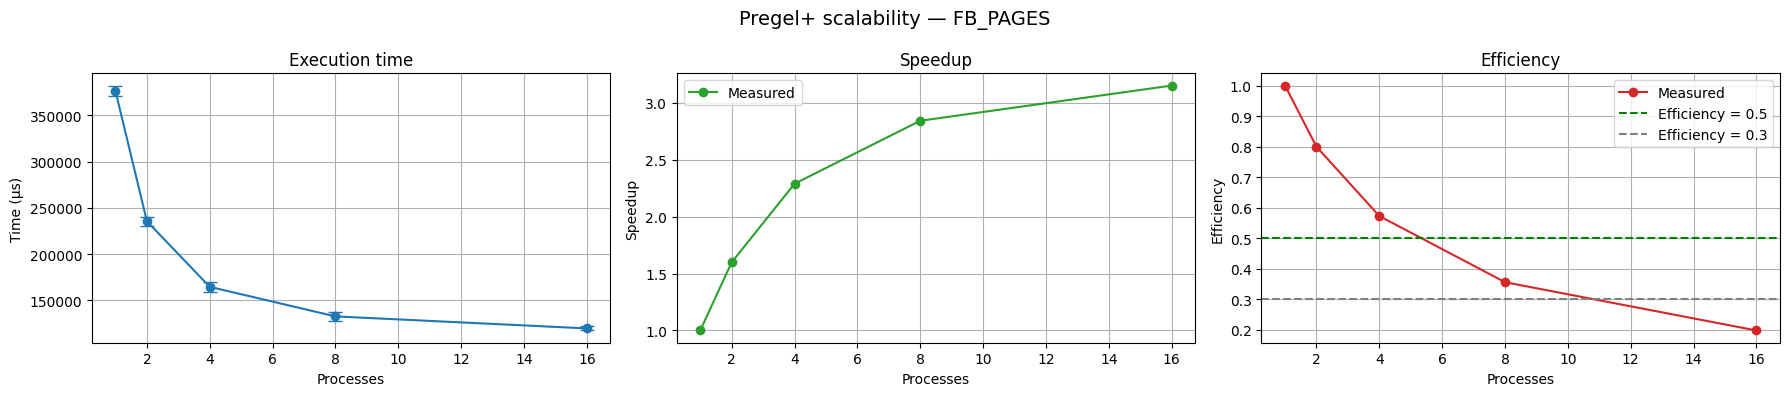

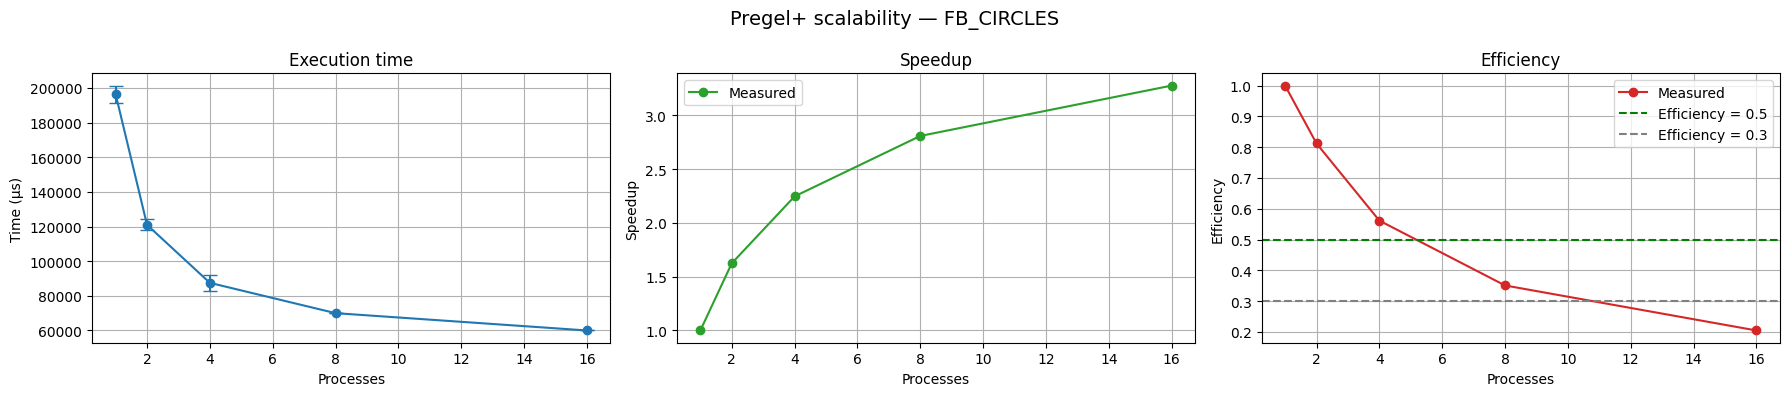

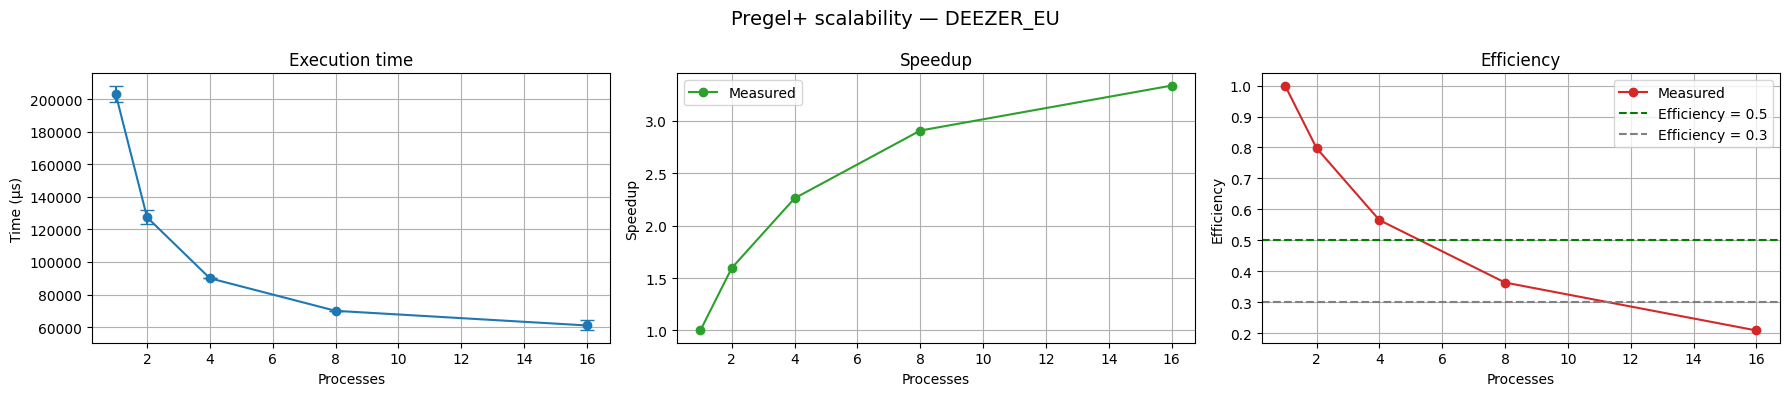

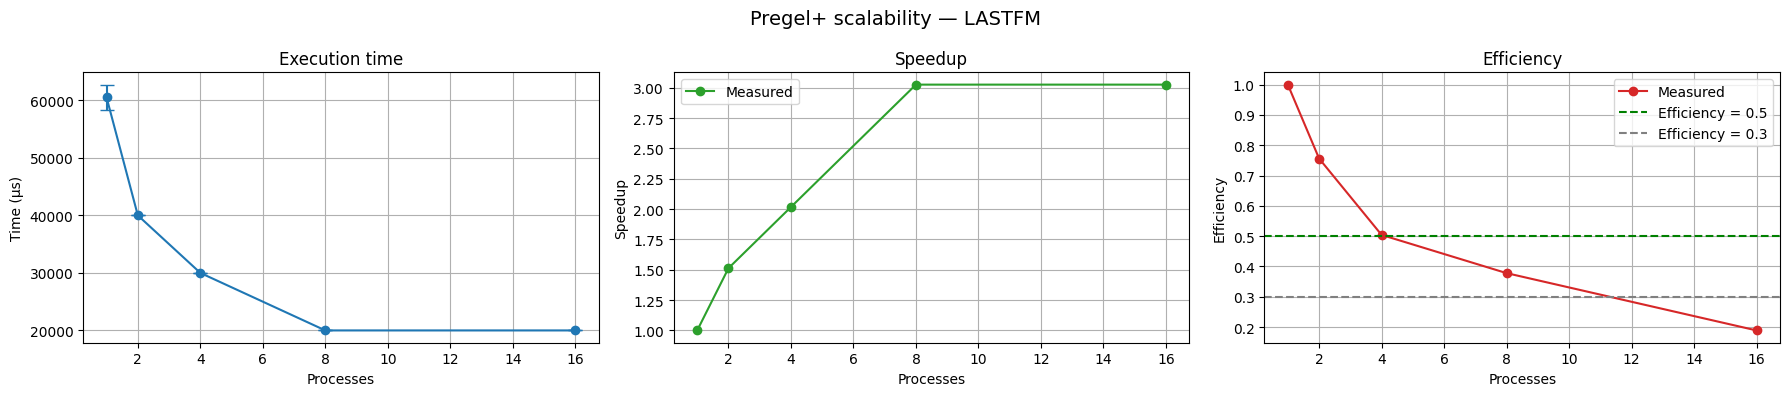

In [12]:
for graph in PREFIXES_SNAP:
    path = os.path.join(
        pregel_results_abs_path,
        f"{graph}_msbfs_results",
        f"{graph}_time_msbfs.txt"
    )

    ps_raw, times_raw = read_time_file(path)
    ps, means, stds = aggregate_by_np(ps_raw, times_raw)

    plot_scalability_row(ps, means, stds, graph, time_unit="us")

In [13]:
def plot_speedup_multi(graphs, algorithm="mst"):
    plt.figure(figsize=(7,5))

    for graph in graphs:
        if algorithm == "mst":
            path = os.path.join(
                pregel_results_abs_path,
                f"{graph}_mst_results",
                f"{graph}_time_mst.txt"
            )
        elif algorithm == "msbfs":
            path = os.path.join(
                pregel_results_abs_path,
                f"{graph}_msbfs_results",
                f"{graph}_time_msbfs.txt"
            )
        else:
            raise ValueError("Unknown algorithm")

        if not os.path.exists(path):
            continue

        ps_raw, times_raw = read_time_file(path)
        ps, means, _ = aggregate_by_np(ps_raw, times_raw)

        if 1 not in ps:
            continue

        T1 = means[ps == 1][0]
        speedup = T1 / means

        plt.plot(ps, speedup, marker="o", label=graph)

    plt.xlabel("Processes")
    plt.ylabel("Speedup")
    plt.title(
        "Pregel+ speedup comparison (Borůvka)"
        if algorithm == "mst"
        else "Pregel+ speedup comparison (MS-Parent BFS)"
    )
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [14]:
def plot_efficiency_multi(graphs, algorithm="mst"):
    plt.figure(figsize=(7,5))

    for graph in graphs:
        if algorithm == "mst":
            path = os.path.join(
                pregel_results_abs_path,
                f"{graph}_mst_results",
                f"{graph}_time_mst.txt"
            )
        elif algorithm == "msbfs":
            path = os.path.join(
                pregel_results_abs_path,
                f"{graph}_msbfs_results",
                f"{graph}_time_msbfs.txt"
            )
        else:
            raise ValueError("Unknown algorithm")

        if not os.path.exists(path):
            continue

        ps_raw, times_raw = read_time_file(path)
        ps, means, _ = aggregate_by_np(ps_raw, times_raw)

        if 1 not in ps:
            continue

        T1 = means[ps == 1][0]
        efficiency = (T1 / means) / ps

        plt.plot(ps, efficiency, marker="o", label=graph)

    plt.axhline(0.5, linestyle="--", color="green", label="Efficiency = 0.5")
    plt.axhline(0.3, linestyle="--", color="gray", label="Efficiency = 0.3")
    plt.xlabel("Processes")
    plt.ylabel("Efficiency")
    plt.title(
        "Pregel+ efficiency comparison (Borůvka)"
        if algorithm == "mst"
        else "Pregel+ efficiency comparison (MS-Parent BFS)"
    )
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


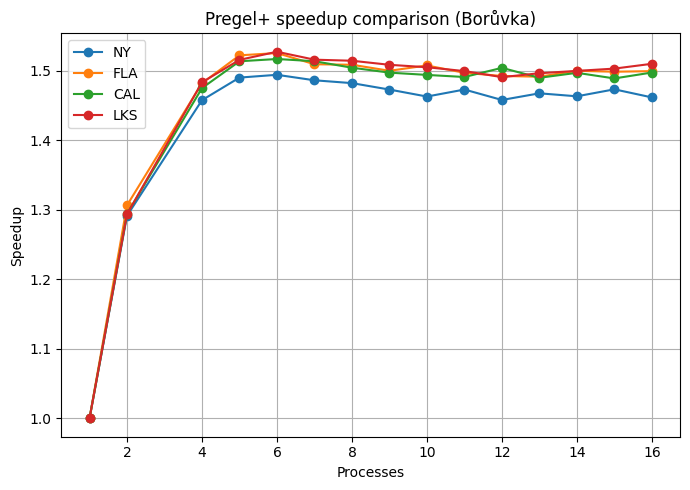

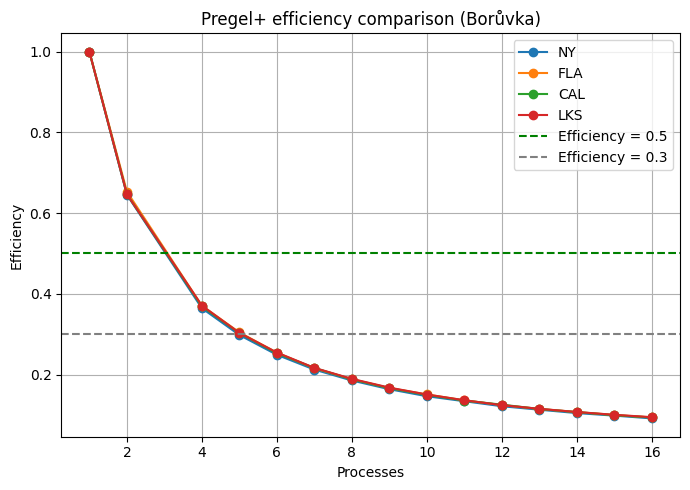

In [15]:
plot_speedup_multi(["NY", "FLA", "CAL", "LKS"], algorithm="mst")
plot_efficiency_multi(["NY", "FLA", "CAL", "LKS"], algorithm="mst")


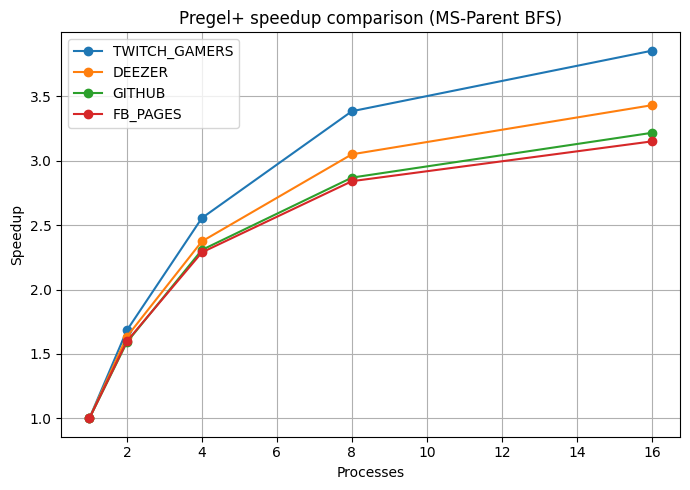

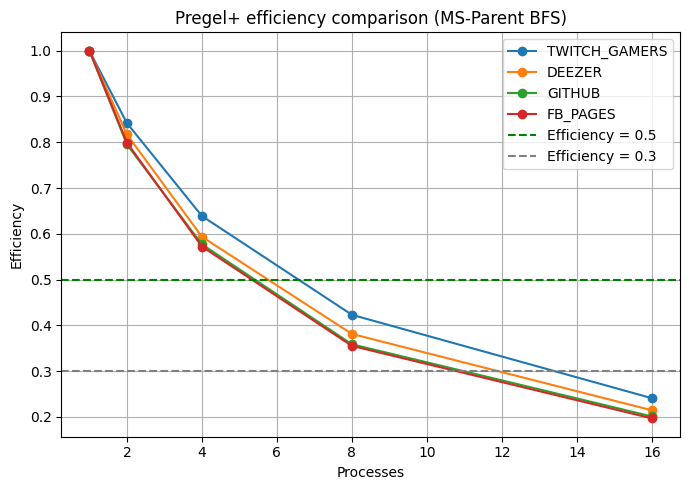

In [16]:
plot_speedup_multi(
    ["TWITCH_GAMERS", "DEEZER", "GITHUB", "FB_PAGES"],
    algorithm="msbfs"
)

plot_efficiency_multi(
    ["TWITCH_GAMERS", "DEEZER", "GITHUB", "FB_PAGES"],
    algorithm="msbfs"
)


In [19]:
def plot_comm_comp_sidebars(graphs, algorithm="mst", p_fixed=8):
    labels, comp_m, comm_m = [], [], []

    for graph in graphs:
        path = os.path.join(
            pregel_results_abs_path,
            f"{graph}_{'mst' if algorithm=='mst' else 'msbfs'}_results",
            f"{graph}_{'comm_comp' if algorithm=='mst' else 'comm_comp_msbfs'}.txt"
        )

        for line in open(path):
            p, comm, comp = map(float, line.split())
            if int(p) == p_fixed:
                comm_m.append(comm)
                comp_m.append(comp)
                labels.append(graph)
                break

    x = np.arange(len(labels))
    w = 0.35

    # единицы измерения
    if algorithm == "mst":
        ylabel = "Time (s)"
        title_alg = "Borůvka"
    else:
        ylabel = "Time (μs)"
        title_alg = "MS-Parent BFS"

    plt.figure(figsize=(9,5))
    plt.bar(x - w/2, comp_m, w, label="Computation")
    plt.bar(x + w/2, comm_m, w, label="Communication")

    plt.xticks(x, labels, rotation=25)
    plt.ylabel(ylabel)
    plt.xlabel("Graph")
    plt.title(f"Pregel+ {title_alg}: communication vs computation (p = {p_fixed})")
    plt.legend()
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()


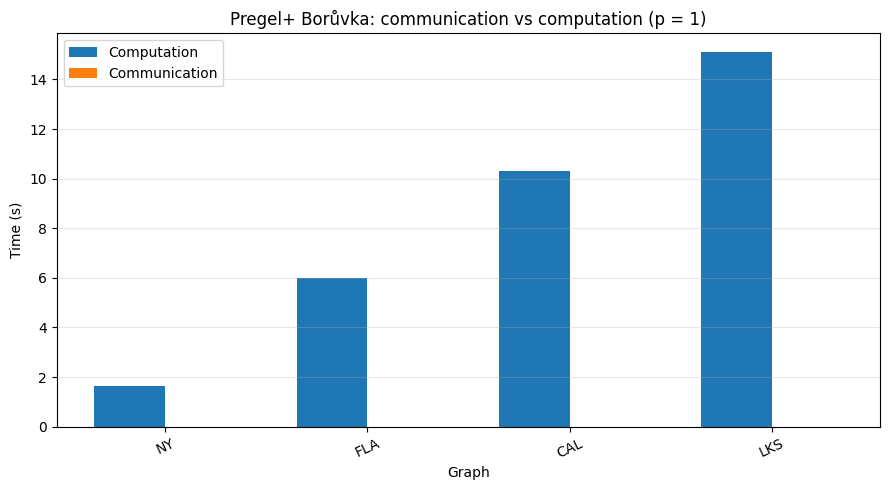

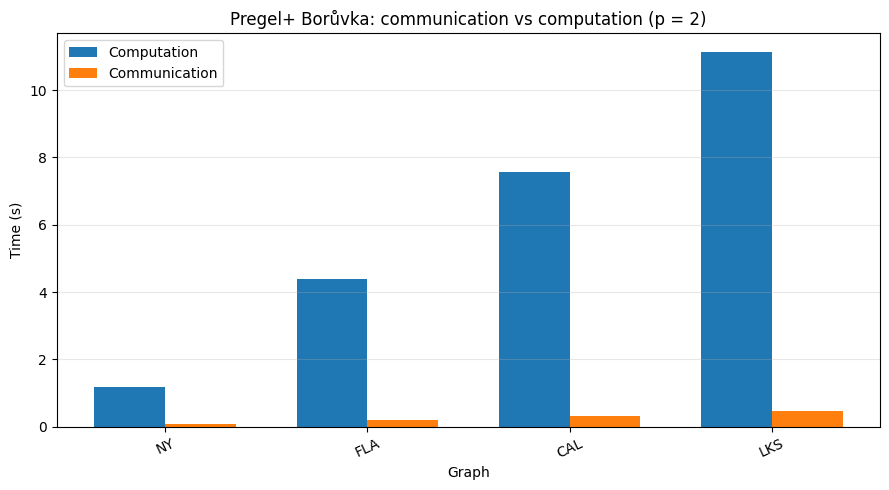

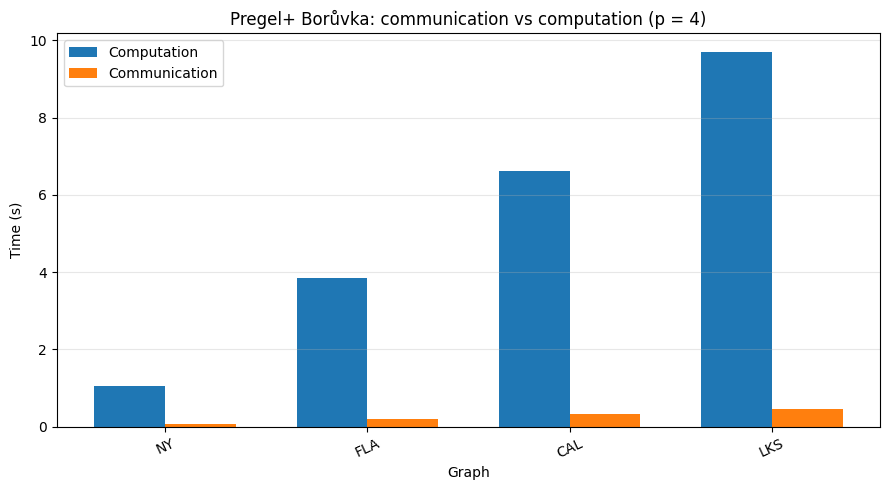

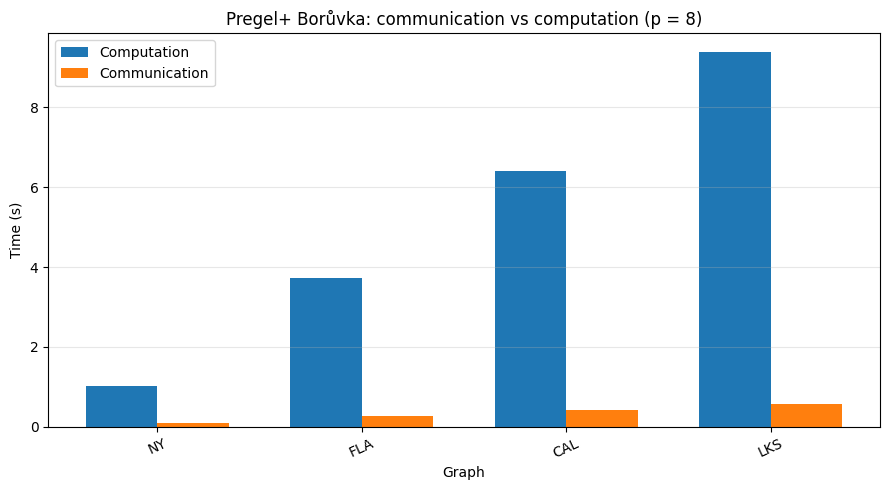

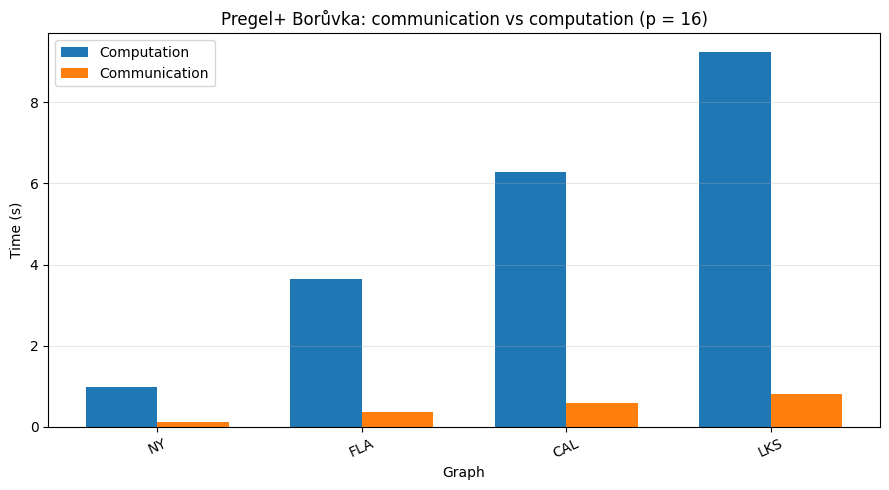

In [21]:
plot_comm_comp_sidebars(
    graphs=["NY", "FLA", "CAL", "LKS"],
    algorithm="mst",
    p_fixed=1
)

plot_comm_comp_sidebars(
    graphs=["NY", "FLA", "CAL", "LKS"],
    algorithm="mst",
    p_fixed=2
)

plot_comm_comp_sidebars(
    graphs=["NY", "FLA", "CAL", "LKS"],
    algorithm="mst",
    p_fixed=4
)

plot_comm_comp_sidebars(
    graphs=["NY", "FLA", "CAL", "LKS"],
    algorithm="mst",
    p_fixed=8
)
plot_comm_comp_sidebars(
    graphs=["NY", "FLA", "CAL", "LKS"],
    algorithm="mst",
    p_fixed=16
)

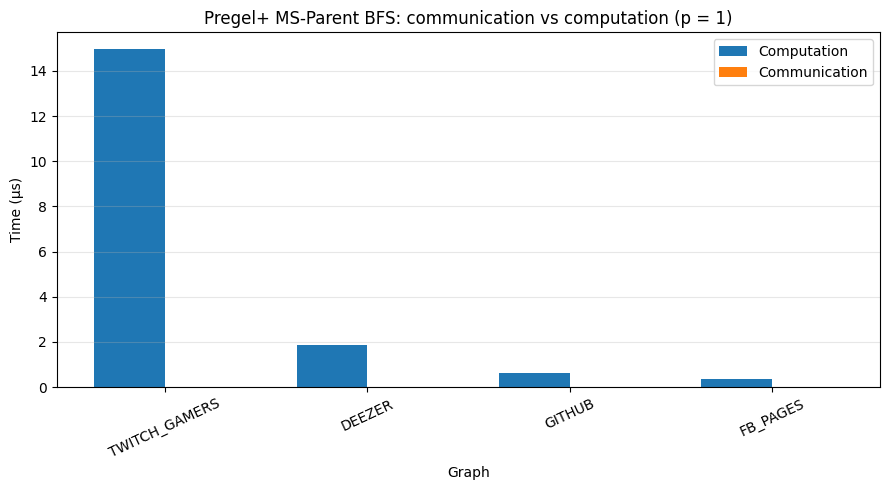

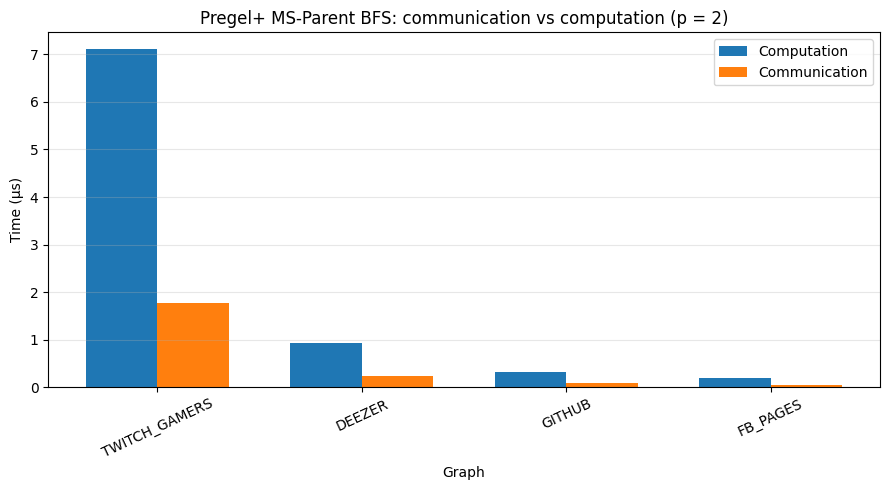

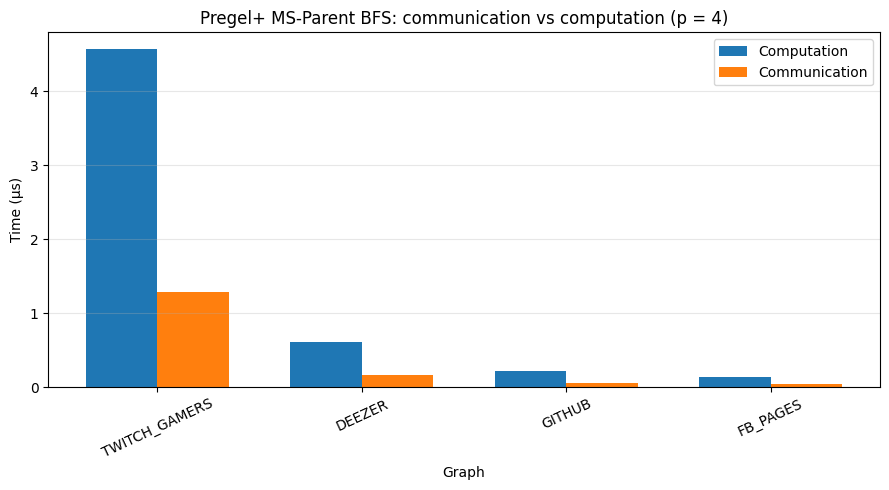

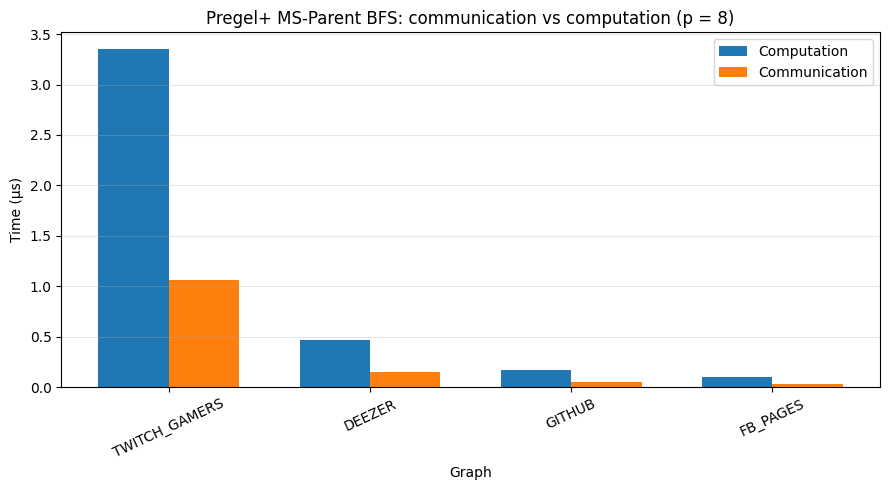

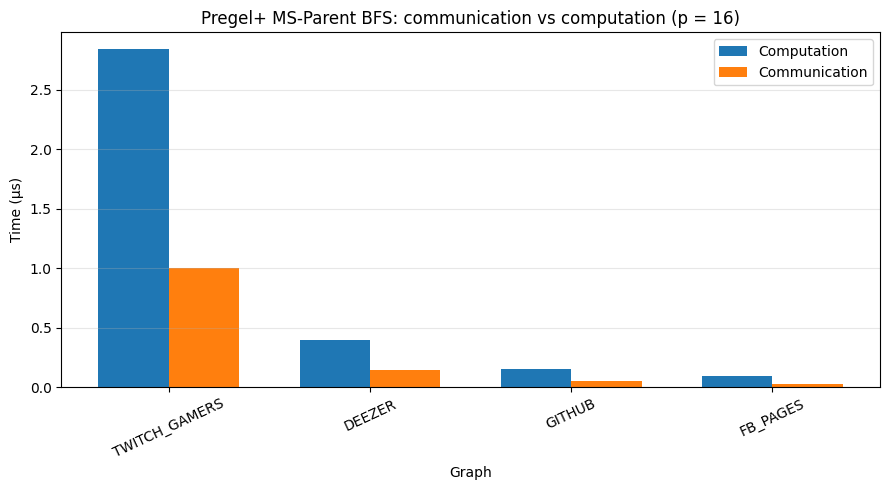

In [20]:
plot_comm_comp_sidebars(
    graphs=["TWITCH_GAMERS", "DEEZER", "GITHUB", "FB_PAGES"],
    algorithm="msbfs",
    p_fixed=1
)
plot_comm_comp_sidebars(
    graphs=["TWITCH_GAMERS", "DEEZER", "GITHUB", "FB_PAGES"],
    algorithm="msbfs",
    p_fixed=2
)

plot_comm_comp_sidebars(
    graphs=["TWITCH_GAMERS", "DEEZER", "GITHUB", "FB_PAGES"],
    algorithm="msbfs",
    p_fixed=4
)

plot_comm_comp_sidebars(
    graphs=["TWITCH_GAMERS", "DEEZER", "GITHUB", "FB_PAGES"],
    algorithm="msbfs",
    p_fixed=8
)
plot_comm_comp_sidebars(
    graphs=["TWITCH_GAMERS", "DEEZER", "GITHUB", "FB_PAGES"],
    algorithm="msbfs",
    p_fixed=16
)


In [ ]:
SMT_OFF_BASE = pregel_results_abs_path
SMT_ON_BASE  = "./pregel_results_with_SMT"

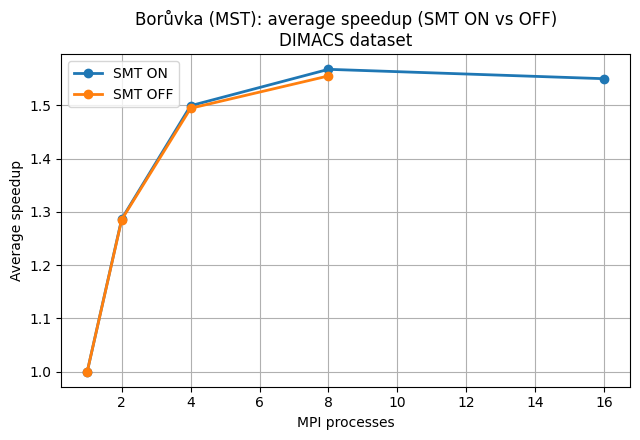

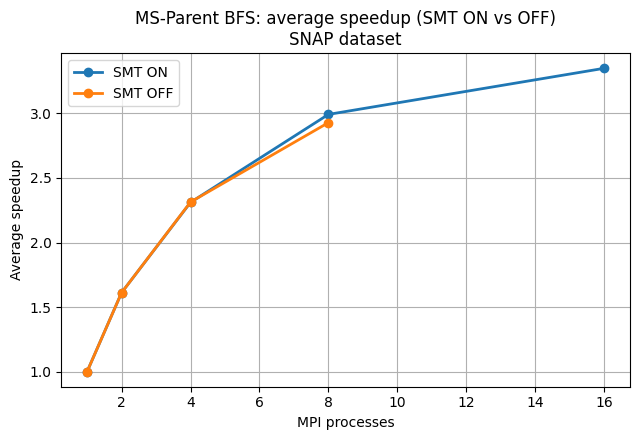

In [51]:
def plot_average_speedup_smt(
    graphs,
    algorithm="mst",
    title_suffix=""
):
    if algorithm == "mst":
        fname_tpl = "{}_time_mst.txt"
        subdir_tpl = "{}_mst_results"
        title_alg = "Borůvka (MST)"
    elif algorithm == "msbfs":
        fname_tpl = "{}_time_msbfs.txt"
        subdir_tpl = "{}_msbfs_results"
        title_alg = "MS-Parent BFS"
    else:
        raise ValueError("Unknown algorithm")

    base_paths = {
        "SMT ON":  SMT_ON_BASE,
        "SMT OFF": SMT_OFF_BASE,
    }

    plt.figure(figsize=(6.5, 4.5))

    for smt_label, base in base_paths.items():
        speedups_acc = {}

        for graph in graphs:
            path = os.path.join(
                base,
                subdir_tpl.format(graph),
                fname_tpl.format(graph)
            )

            if not os.path.exists(path):
                continue

            ps_raw, times_raw = read_time_file(path)
            ps, means, _ = aggregate_by_np(ps_raw, times_raw)

            if 1 not in ps:
                continue

            T1 = means[ps == 1][0]
            speedup = T1 / means

            for p, s in zip(ps, speedup):
                speedups_acc.setdefault(p, []).append(s)

        ps_sorted = sorted(speedups_acc.keys())
        avg_speedup = [
            sum(speedups_acc[p]) / len(speedups_acc[p])
            for p in ps_sorted
        ]

        plt.plot(
            ps_sorted,
            avg_speedup,
            marker="o",
            linewidth=2,
            label=smt_label
        )

    plt.xlabel("MPI processes")
    plt.ylabel("Average speedup")
    plt.title(
        f"{title_alg}: average speedup (SMT ON vs OFF)\n{title_suffix}"
    )
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_average_speedup_smt(
    graphs=PREFIXES_DIMACS,
    algorithm="mst",
    title_suffix="DIMACS dataset"
)

plot_average_speedup_smt(
    graphs=PREFIXES_SNAP,
    algorithm="msbfs",
    title_suffix="SNAP dataset"
)

